In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary

import matplotlib.pyplot as plt
import time
import os
import PIL
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [53]:
from loaders.data_loader import *
from trainers.trainer import *

In [54]:
batch_size = 16
num_workers = 1
img_dir = "data/Foot Ulcer Segmentation Challenge/train/images"
mask_dir = "data/Foot Ulcer Segmentation Challenge/train/labels"

img_dir_val = "data/Foot Ulcer Segmentation Challenge/validation/images"
mask_dir_val = "data/Foot Ulcer Segmentation Challenge/validation/labels"
img_dir

'data/Foot Ulcer Segmentation Challenge/train/images'

In [55]:
data_transforms = data_preprocessing_unet()

image_loader_train = ImageLoader(img_dir, mask_dir=mask_dir, 
                                    image_tform=data_transforms['train'], 
                                    mask_tform=data_transforms['train'], 
                                    imgloader=PIL.Image.open)

dataset_train_size = len(image_loader_train)
dataloader_train = torch.utils.data.DataLoader(image_loader_train, 
                                                batch_size=batch_size, 
                                                shuffle=False, drop_last=True, 
                                                num_workers=num_workers)

image_loader_valid = ImageLoader(img_dir_val, mask_dir=mask_dir_val, 
                                    image_tform=data_transforms['valid'], 
                                    mask_tform=data_transforms['valid'], 
                                    imgloader=PIL.Image.open)
dataset_valid_size = len(image_loader_valid)
dataloader_valid = torch.utils.data.DataLoader(image_loader_valid, 
                                                batch_size=batch_size, 
                                                shuffle=False, drop_last=True, 
                                                num_workers=num_workers)

dataloaders = {'train': dataloader_train, 'valid': dataloader_valid}
dataset_sizes = {'train': dataset_train_size, 'valid': dataset_valid_size}

In [56]:
train_features, train_labels = next(iter(dataloaders['train']))
valid_features, valid_labels = next(iter(dataloaders['valid']))
print(train_features.size())
print(train_features.shape)

torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])


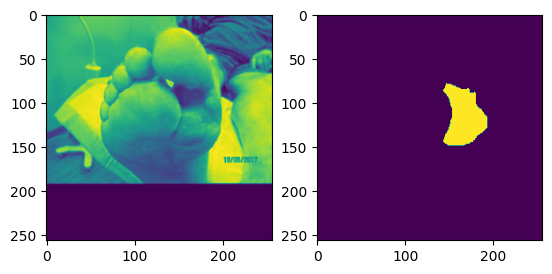

In [61]:
f, ax = plt.subplots(1,2)
ax[0].imshow(train_features[0][0])
ax[1].imshow(train_labels[0][0])


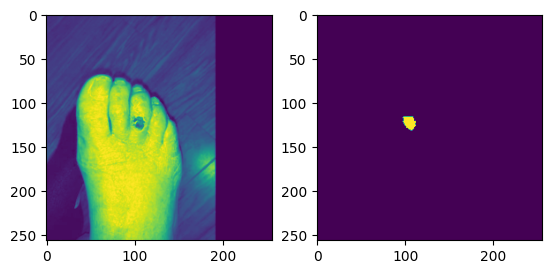

In [62]:
f, ax = plt.subplots(1,2)
ax[0].imshow(valid_features[0][0])
ax[1].imshow(valid_labels[0][0])

In [8]:
from models.tiny_unet import *
model = TinyUNet(in_channels=3, num_classes=2)
# from models.unet_model_zoo import UNet
# model = UNet(pretrained=True, out_channels=2)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Device is: {device}")

Device is: cuda:0


In [10]:
loss = nn.CrossEntropyLoss()

def UnetLoss(preds, targets):
    ce_loss = loss(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

criterion = UnetLoss

# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

ckpt_folder = "./ckpt"

In [11]:
model_res = train_model(model=model, 
                        criterion=criterion, 
                        optimizer=optimizer, 
                        scheduler=exp_lr_scheduler, 
                        device=device, 
                        dataloaders=dataloaders, 
                        dataset_sizes=dataset_sizes, 
                        ckpt_folder=ckpt_folder, 
                        num_epochs=4)

Epoch 0/3
---------------------------------------------------------------------------
train Loss: 0.2464 Acc: 0.9573
train Epoch completed in: 0m 14s
valid Loss: 0.4441 Acc: 0.9482
valid Epoch completed in: 0m 15s

Epoch 1/3
---------------------------------------------------------------------------
train Loss: 0.0609 Acc: 0.9774
train Epoch completed in: 0m 28s
valid Loss: 0.1255 Acc: 0.9482
valid Epoch completed in: 0m 30s

Epoch 2/3
---------------------------------------------------------------------------
train Loss: 0.0350 Acc: 0.9804
train Epoch completed in: 0m 43s
valid Loss: 0.0573 Acc: 0.9489
valid Epoch completed in: 0m 45s

Epoch 3/3
---------------------------------------------------------------------------
train Loss: 0.0247 Acc: 0.9818
train Epoch completed in: 0m 59s
valid Loss: 0.0260 Acc: 0.9532
valid Epoch completed in: 1m 0s

Training completed in 1m 0s
Best valid accuracy: 0.953236


In [12]:
def infer(model, device, test_loader):

    model.eval()

    results = []
    masks = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            results.append(outputs.cpu().detach().numpy())
            masks.append(labels.cpu().detach().numpy())
            
    return results, masks

In [13]:
res, masks_val = infer(model=model, device=device, test_loader=dataloader_valid)

In [14]:
result_data = np.array(res)
masks_data = np.array(masks_val)

print(result_data.shape)

(12, 16, 2, 256, 256)


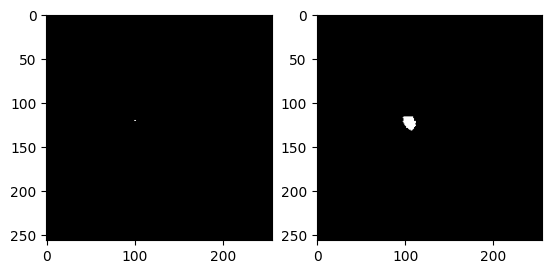

In [15]:
results = result_data.reshape(12 * 16, 2, 256, 256)
predicted_mask = results[:, 1, :, :]

results_masks = masks_data.reshape(12 * 16, 1, 256, 256)
true_mask = results_masks[:, 0, :, :]

predicted_mask = np.where(predicted_mask[0] < 0.2, 5, 255)

f, ax = plt.subplots(1,2)
ax[0].imshow(predicted_mask, cmap='gray')
ax[1].imshow(true_mask[0], cmap='gray')
plt.show()


In [ ]:
from thop import profile
from thop import clever_format
import torch
import torchvision.models as models

# Example: Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)

# Example input (batch size = 1, 3 channels, 224x224 image)
input = torch.randn(1, 3, 224, 224)

# Calculate FLOPs and parameters
flops, params = profile(model, inputs=(input,))

# Format the numbers for better readability
flops, params = clever_format([flops, params], "%.3f")

print(f"FLOPs: {flops}")
print(f"Parameters: {params}")


In [16]:
def train_model(model, criterion, optimizer, scheduler, device, dataloaders, dataset_sizes, ckpt_folder, num_epochs=25):
    import random
    import numpy as np
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)
    
    start = time.time()
    model_name = getattr(model, 'name', 'unnamed_model')
    best_model_path = os.path.join(ckpt_folder, f'best_model_{model_name}_params.pt')

    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 75)
        epoch_start = time.time()

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_acc = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device).squeeze(1)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss, acc = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_acc += acc.item() * inputs.size(0)

            if phase == 'train':
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(running_loss / dataset_sizes[phase])
                else:
                    scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_acc / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'best_acc': best_acc,
                    'epoch': epoch,
                }, best_model_path)

        epoch_time = time.time() - epoch_start
        print(f'Epoch completed in: {epoch_time // 60:.0f}m {epoch_time % 60:.0f}s')
        print()

    time_elapsed = time.time() - start
    print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best valid accuracy: {best_acc:4f}')

    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    return model, best_acc


In [ ]:
model_res = train_model(model=model, 
                        criterion=criterion, 
                        optimizer=optimizer, 
                        scheduler=exp_lr_scheduler, 
                        device=device, 
                        dataloaders=dataloaders, 
                        dataset_sizes=dataset_sizes, 
                        ckpt_folder=ckpt_folder, 
                        num_epochs=4)

In [22]:
model_res[0]

TinyUNet(
  (encoder1): UNetEncoder(
    (cmrf): CMRF(
      (pwconv1): Conv(
        (conv): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(8, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): GELU()
      )
      (pwconv2): Conv(
        (conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): GELU()
      )
      (m): ModuleList(
        (0): DWConv(
          (conv): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4, bias=False)
          (bn): BatchNorm2d(4, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): Identity()
        )
        (1): DWConv(
          (conv): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4, bias=False)
          (bn): BatchNorm2d(4, eps=0.001, momentum=0.03, affine=True, track_running_stats

: 